# Download Images

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


# Prepare Images

In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

#Imports from the tutorial
import PIL
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input


In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        #rescale=1./255,
        validation_split=.2
        )


validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        #rescale=1./255,
        validation_split=.2
        )


train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


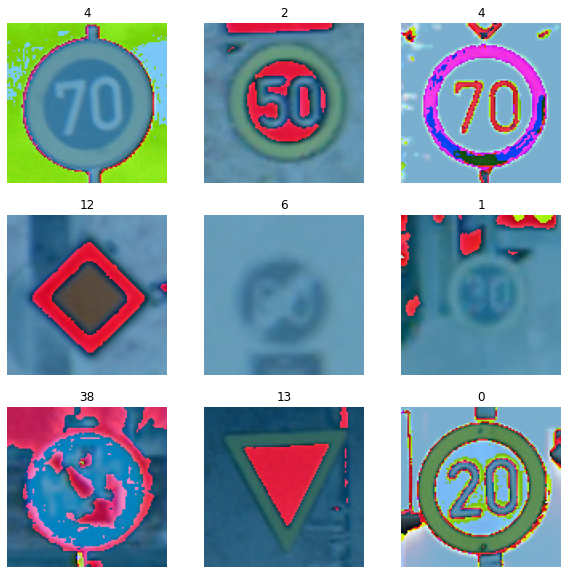

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]      
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [ ]:
class_names = train_generator.allowed_class_modes
len(class_names)

5

#Model Engineering

In [ ]:
# Build a model...
img_height = img_width = 100
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   classes=43,
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)


In [ ]:
resnet_model.add(Flatten())
#resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(256, activation='relu'))
#resnet_model.add(Dense(128, activation='relu'))

resnet_model.add(Dense(43, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dense_12 (Dense)            (None, 43)                22059     
                                                                 
Total params: 26,232,747
Trainable params: 2,645,035
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
981/981 [==============================] - 54s 51ms/step - loss: 0.6548 - accuracy: 0.7860 - val_loss: 1.5279 - val_accuracy: 0.6074
Epoch 2/10
981/981 [==============================] - 48s 49ms/step - loss: 0.2268 - accuracy: 0.9208 - val_loss: 1.7725 - val_accuracy: 0.6225
Epoch 3/10
981/981 [==============================] - 49s 50ms/step - loss: 0.1540 - accuracy: 0.9482 - val_loss: 1.8859 - val_accuracy: 0.6560
Epoch 4/10
981/981 [==============================] - 48s 49ms/step - loss: 0.1204 - accuracy: 0.9597 - val_loss: 1.9357 - val_accuracy: 0.6443
Epoch 5/10
981/981 [==============================] - 48s 49ms/step - loss: 0.1019 - accuracy: 0.9671 - val_loss: 2.1725 - val_accuracy: 0.6338
Epoch 6/10
981/981 [==============================] - 48s 49ms/step - loss: 0.0892 - accuracy: 0.9725 - val_loss: 2.4006 - val_accuracy: 0.6342
Epoch 7/10
981/981 [==============================] - 48s 49ms/step - loss: 0.0711 - accuracy: 0.9782 - val_loss: 2.4559 - val_accuracy:

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before. 

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset. 

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does. 

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```